# CS189 Final Project

Members:

Timothy Quang Nguyen, timotqn2@uci.edu

Aditya Pal Singh, adityapa@uci.edu

## Environment Setup

In [17]:
# # For package installations
# !pip install xgboost
# !pip install scikit-optimize
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install tensorflow

In [18]:

import numpy as np # for data organization
import pandas as pd # for data organization
import sklearn as sk # for machine learning
from sklearn.metrics import (confusion_matrix, accuracy_score, 
                            precision_score, recall_score, 
                            f1_score, roc_auc_score,
                            matthews_corrcoef, balanced_accuracy_score) # For Evaluation
from sklearn.preprocessing import MinMaxScaler # To Scale Features
from sklearn.preprocessing import OneHotEncoder, StandardScaler # To Encode Non-Numeric Columns
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score # For Hyper Parameter Tuning and Data Splitting
from skopt import BayesSearchCV # For Smart Hyper Parameter Tuning
from sklearn.linear_model import LogisticRegression # For Logistic Regression
from sklearn.ensemble import RandomForestClassifier # For Random Forest Classifier
from sklearn.svm import SVC # For Support Vector Classifier
from xgboost import XGBClassifier # For XGB Classifier
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import zipfile as zf # for unzipping data

import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

### Function Declaration

In [19]:
def evaluate_medical_model(y_true, y_pred, y_pred_proba=None, 
                          label_nums=[0,1], label_names=['Benign', 'Malignant']):
    """
    Comprehensive evaluation for medical binary classification.
    
    Parameters:
        y_true: True labels (array-like)
        y_pred: Predicted labels (array-like)
        y_pred_proba: Predicted probabilities (optional, for ROC-AUC)
        label_nums: Numeric labels [negative_class, positive_class]
        label_names: Descriptive label names
    """
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=label_nums)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=label_names, 
                yticklabels=label_names,
                annot_kws={"size": 14})
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.show()

    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Precision (PPV)': precision_score(y_true, y_pred),
        'Recall (Sensitivity)': recall_score(y_true, y_pred),
        'Specificity': tn / (tn + fp),
        'F1 Score': f1_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred)
    }
    
    if y_pred_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred_proba)

    # Print formatted metrics
    print("\nMEDICAL DIAGNOSTICS METRICS")
    print("="*40)
    for name, value in metrics.items():
        if name in ['ROC-AUC', 'MCC']:  # Metrics that don't use percentage
            print(f"{name:<25}: {value:.4f}")
        else:
            print(f"{name:<25}: {value:.2%}")
    
    # Critical medical stats
    print("\nCRITICAL MEDICAL STATISTICS")
    print("="*40)
    print(f"False Negatives (Missed Cancer): {fn}")
    print(f"False Positives (Overdiagnosis): {fp}")
    print(f"Sensitivity (True Positive Rate): {metrics['Recall (Sensitivity)']:.2%}")
    print(f"Specificity (True Negative Rate): {metrics['Specificity']:.2%}")

In [20]:
# Used to produce confusion matrices and accuracy metrics for models
def confusion_matrix_and_metrics(y_te, y_pred, label_nums, label_names):
    
    # Used to produce a pretty Confusion Matrix
    cm = confusion_matrix(y_te, y_pred, labels=label_nums)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Used to produce metric data, precision, recall, F1 score, accuracy

    print("Precision of the MLP :\t" + str(precision_score(y_te, y_pred, average="macro")))
    print("Recall of the MLP    :\t" + str(recall_score(y_te, y_pred, average="macro")))
    print("F1 Score of the Model :\t" + str(f1_score(y_te, y_pred, average="macro")))
    print("Accuracy Score of the Model :\t" + str(round(accuracy_score(y_te, y_pred) * 100, 2)) + "%")

In [21]:
# Search for all column names that don't match
def non_matching_columns(data_one, data_two):
    non_matching = [] # list that will consist of tuples of mismatched columns

    data_one_cols = data_one.columns
    data_two_cols = data_two.columns
    
    for index in range(len(data_one_cols)):
        if data_one_cols[index] != data_two_cols[index]:
            non_matching.append((data_one_cols[index], data_two_cols[index]))

    return non_matching

In [22]:
# To showcase general data properties
def print_general_data_properties(data):
    rows, cols = data.shape

    print("Number of rows: ", rows)
    print("Number of columns: ", cols)
    print()
    print("All Columns:\n", data.columns)
    print()
    print("Column Types:\n", data.dtypes)

In [23]:
# Code to extract dataset from zip (Don't need to run)

files = zf.ZipFile('archive.zip', 'r')
files.extractall('dataset')
files.close()

## Loading Data

In [24]:
# Define paths (adjust as needed)
train_path = './dataset/Features_Train.csv'
test_path = './dataset/Lung Nodule/Lung Nodule/Features_Test.csv'

# Load data with error handling
try:
    train_data = pd.read_csv(train_path)
    print("Train data loaded successfully. Shape:", train_data.shape)
except FileNotFoundError:
    print(f"Error: {train_path} not found. Check the path or Kaggle dataset structure.")

try:
    test_data = pd.read_csv(test_path)
    print("Test data loaded successfully. Shape:", test_data.shape)
except FileNotFoundError:
    print(f"Error: {test_path} not found. Ensure the path matches the Kaggle folder.")

Train data loaded successfully. Shape: (609, 2000)
Test data loaded successfully. Shape: (127, 2000)


## Exploring Data

In [25]:
# Basic info
df = pd.read_csv(train_path)  
print("="*50)
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
display(df.head())

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values per Column:")
print(df.isnull().sum())

print("\nDescriptive Statistics:")
display(df.describe(include='all'))

Dataset Shape: (609, 2000)

First 5 Rows:


,ID,Annulus_N.voxels,Annulus_SNS_vol,Annulus_SNS_area,Annulus_SNS_s2v,Annulus_SNS_sph,Annulus_SNS_sph_dis,Annulus_SNS_com_1,Annulus_SNS_com_2,Annulus_SNS_max3d,...,Lesion_GLCM_sumEnt_HHH_25HUgl,Lesion_GLCM_difVar_HHH_25HUgl,Lesion_GLCM_difEnt_HHH_25HUgl,Lesion_GLCM_AutoCorrel_HHH_25HUgl,Lesion_GLCM_ClTend_HHH_25HUgl,Lesion_GLCM_Homoge1_HHH_25HUgl,Lesion_GLCM_IDMN_HHH_25HUgl,Lesion_GLCM_IDN_HHH_25HUgl,Lesion_GLCM_invVar_HHH_25HUgl,Outcome
0,0001_1,1504,1504,3364,2.236702,0.188709,5.299155,3.779511,0.006720,21,...,1.456343,0.516489,1.478822,12.359264,1.122325,0.672912,0.972564,0.898164,0.519051,0
1,0003_1,1007,1007,2224,2.208540,0.218459,4.577528,3.334505,0.010426,16,...,1.462379,0.535239,1.502895,12.134616,1.132018,0.675078,0.971933,0.898085,0.502191,0
2,0004_1,2160,2160,4322,2.000926,0.186969,5.348493,4.592921,0.006536,17,...,1.050196,0.245968,0.988000,2.261923,0.527141,0.763604,0.905442,0.842403,0.472791,1
3,0005_1,1568,1568,3276,2.089286,0.199237,5.019137,4.010592,0.007909,23,...,1.157852,0.299988,1.146312,6.241820,0.605958,0.733500,0.965438,0.891646,0.504706,1
4,0006_1,779,779,1702,2.184852,0.240556,4.157036,3.083113,0.013920,14,...,1.414994,0.484908,1.434273,6.282063,1.046868,0.692436,0.964913,0.889447,0.487179,0



Data Types:
ID                                 object
Annulus_N.voxels                    int64
Annulus_SNS_vol                     int64
Annulus_SNS_area                    int64
Annulus_SNS_s2v                   float64
                                   ...   
Lesion_GLCM_Homoge1_HHH_25HUgl    float64
Lesion_GLCM_IDMN_HHH_25HUgl       float64
Lesion_GLCM_IDN_HHH_25HUgl        float64
Lesion_GLCM_invVar_HHH_25HUgl     float64
Outcome                             int64
Length: 2000, dtype: object

Missing Values per Column:
ID                                0
Annulus_N.voxels                  0
Annulus_SNS_vol                   0
Annulus_SNS_area                  0
Annulus_SNS_s2v                   0
                                 ..
Lesion_GLCM_Homoge1_HHH_25HUgl    0
Lesion_GLCM_IDMN_HHH_25HUgl       0
Lesion_GLCM_IDN_HHH_25HUgl        0
Lesion_GLCM_invVar_HHH_25HUgl     0
Outcome                           0
Length: 2000, dtype: int64

Descriptive Statistics:


,ID,Annulus_N.voxels,Annulus_SNS_vol,Annulus_SNS_area,Annulus_SNS_s2v,Annulus_SNS_sph,Annulus_SNS_sph_dis,Annulus_SNS_com_1,Annulus_SNS_com_2,Annulus_SNS_max3d,...,Lesion_GLCM_sumEnt_HHH_25HUgl,Lesion_GLCM_difVar_HHH_25HUgl,Lesion_GLCM_difEnt_HHH_25HUgl,Lesion_GLCM_AutoCorrel_HHH_25HUgl,Lesion_GLCM_ClTend_HHH_25HUgl,Lesion_GLCM_Homoge1_HHH_25HUgl,Lesion_GLCM_IDMN_HHH_25HUgl,Lesion_GLCM_IDN_HHH_25HUgl,Lesion_GLCM_invVar_HHH_25HUgl,Outcome
count,609,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,...,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000
unique,609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0652_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1259.469622,1259.469622,2671.569787,2.165722,0.223115,4.614327,3.522902,0.012112,18.103448,...,1.281782,0.618323,1.287216,10.695236,1.418486,0.702979,0.944430,0.871894,0.486159,0.500821
std,NaN,781.059290,781.059290,1571.402171,0.123275,0.038307,0.790806,0.799681,0.006447,5.289090,...,0.339138,1.572550,0.427157,25.299462,3.989490,0.084832,0.029017,0.026497,0.042954,0.500410
min,NaN,215.000000,215.000000,512.000000,1.873045,0.128838,2.950033,1.792757,0.002139,9.000000,...,0.918579,0.213436,0.888238,1.892398,0.444633,0.250460,0.885065,0.778880,0.173105,0.000000
25%,NaN,689.000000,689.000000,1534.000000,2.071782,0.195504,4.059633,2.922992,0.007472,14.000000,...,1.052084,0.247663,0.993229,2.303307,0.527072,0.673312,0.907163,0.844430,0.476038,0.000000
50%,NaN,1075.000000,1075.000000,2320.000000,2.154535,0.220222,4.540879,3.481298,0.010680,18.000000,...,1.135323,0.293510,1.118035,6.233043,0.603781,0.736605,0.956450,0.876571,0.492930,1.000000
75%,NaN,1640.000000,1640.000000,3468.000000,2.250811,0.246328,5.114993,4.066343,0.014947,21.000000,...,1.419896,0.503024,1.453010,11.811023,1.078765,0.758378,0.968956,0.895261,0.507205,1.000000


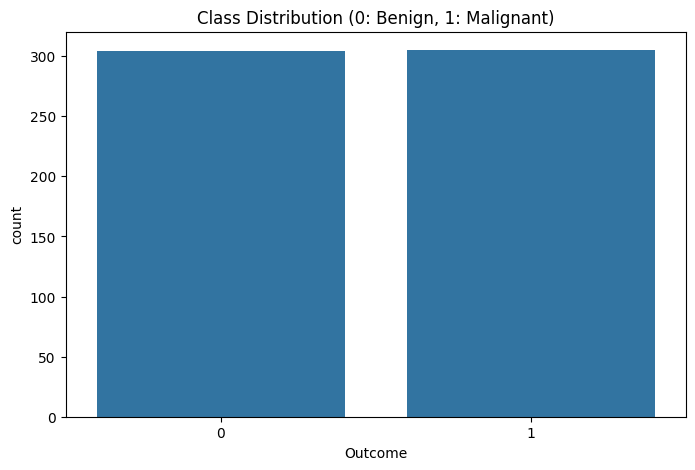

Class Distribution (%):
Outcome
1    50.082102
0    49.917898
Name: proportion, dtype: float64


In [26]:
# Class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Outcome')
plt.title('Class Distribution (0: Benign, 1: Malignant)')
plt.show()

# Percentage breakdown
class_dist = df['Outcome'].value_counts(normalize=True) * 100
print(f"Class Distribution (%):\n{class_dist}")

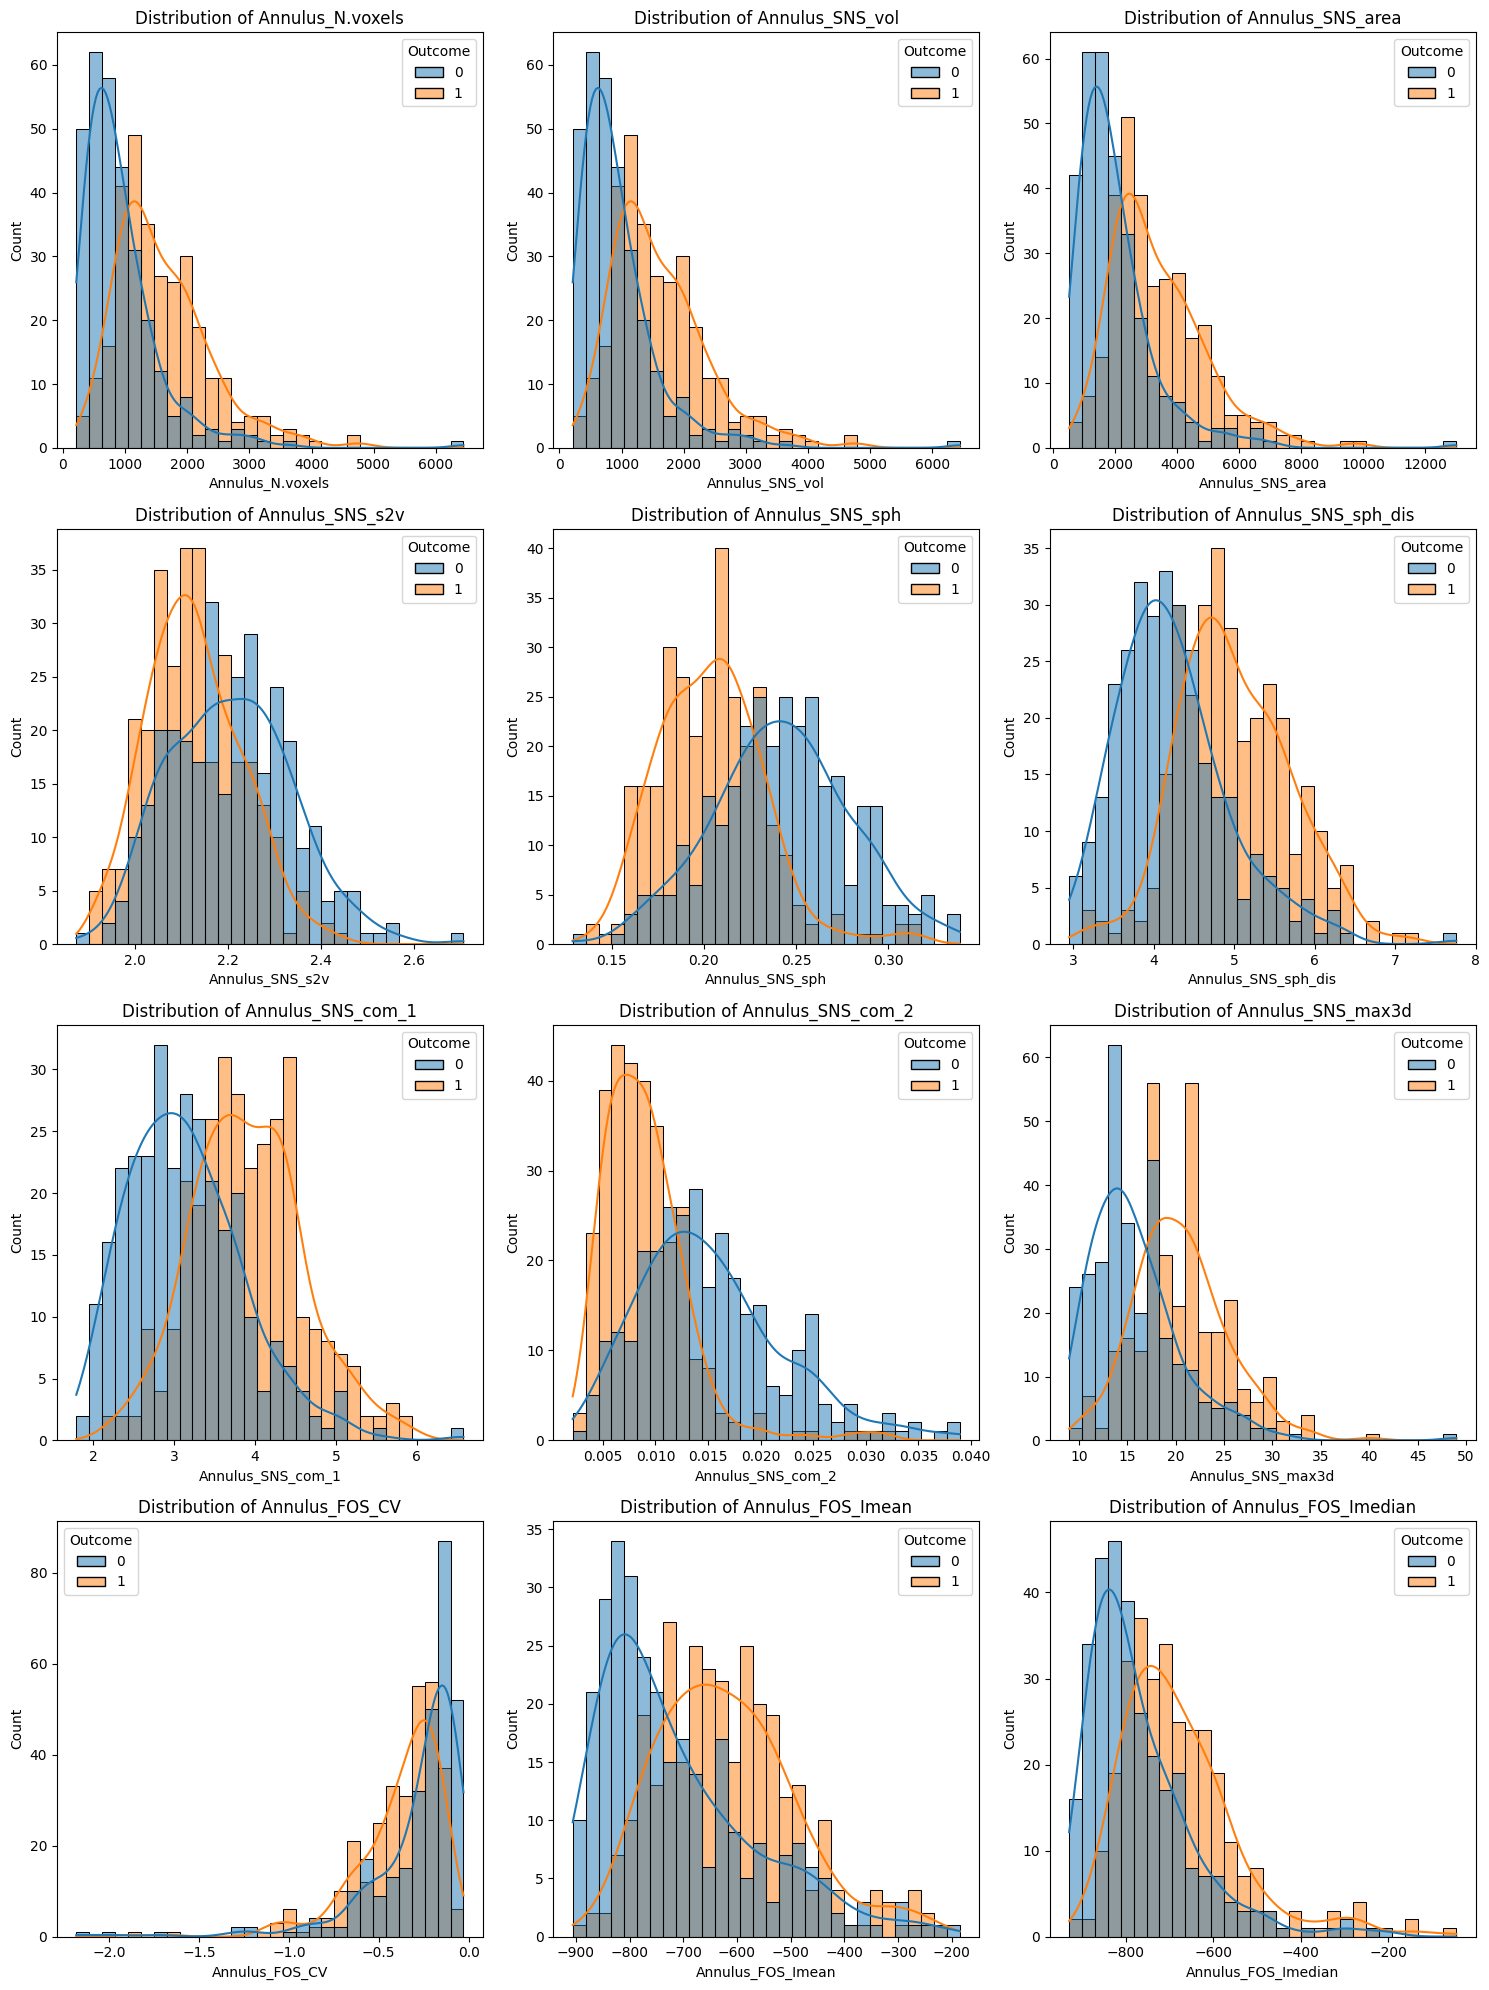

In [27]:
# Select numeric columns (excluding Outcome)
numeric_cols = df.select_dtypes(include=np.number).columns.drop('Outcome')

# Plot distributions
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_cols[:12]):  # First 12 for brevity
    plt.subplot(4, 3, i+1)
    sns.histplot(data=df, x=col, kde=True, hue='Outcome', bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

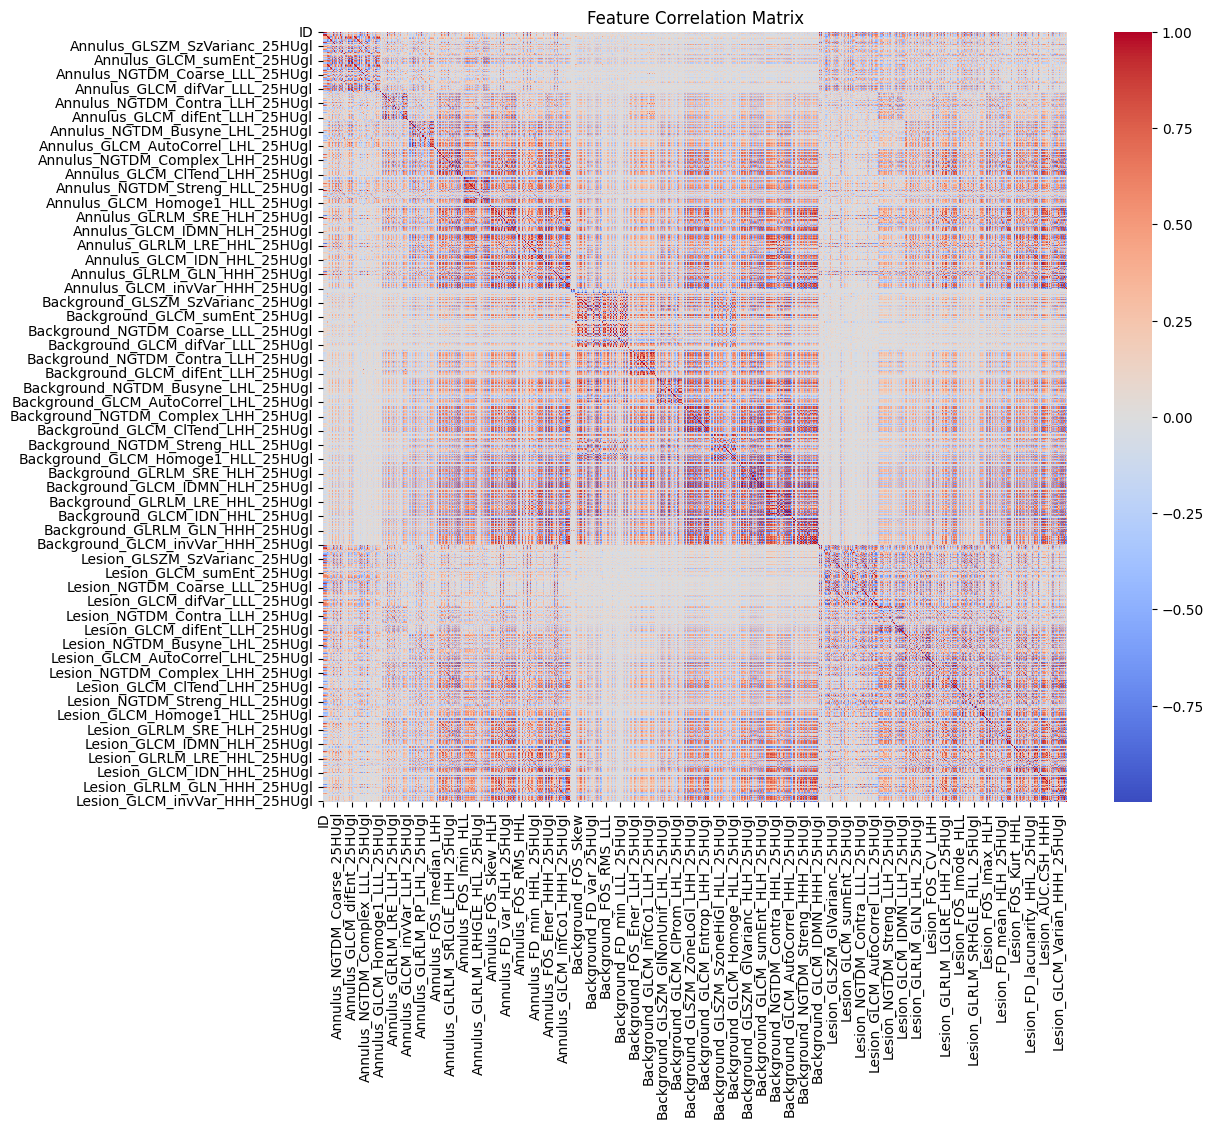

Top 10 Features Correlated with Outcome:
Outcome                           1.000000
Lesion_GLCM_InfCo2_LHL_25HUgl     0.537605
Annulus_GLCM_Entrop_LLL_25HUgl    0.534242
Lesion_GLCM_InfCo2_HLL_25HUgl     0.516611
Lesion_GLCM_IDMN_LLL_25HUgl       0.513468
Lesion_GLCM_IDMN_25HUgl           0.508392
Lesion_GLCM_InfCo2_LLH_25HUgl     0.505760
Lesion_GLCM_InfCo2_LHH_25HUgl     0.504480
Lesion_GLCM_IDN_LLL_25HUgl        0.503877
Lesion_GLCM_InfCo1_LLL_25HUgl     0.498689
Name: Outcome, dtype: float64


In [28]:
# Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Top correlations with Outcome
outcome_corr = corr_matrix['Outcome'].abs().sort_values(ascending=False)
print("Top 10 Features Correlated with Outcome:")
print(outcome_corr.head(10))

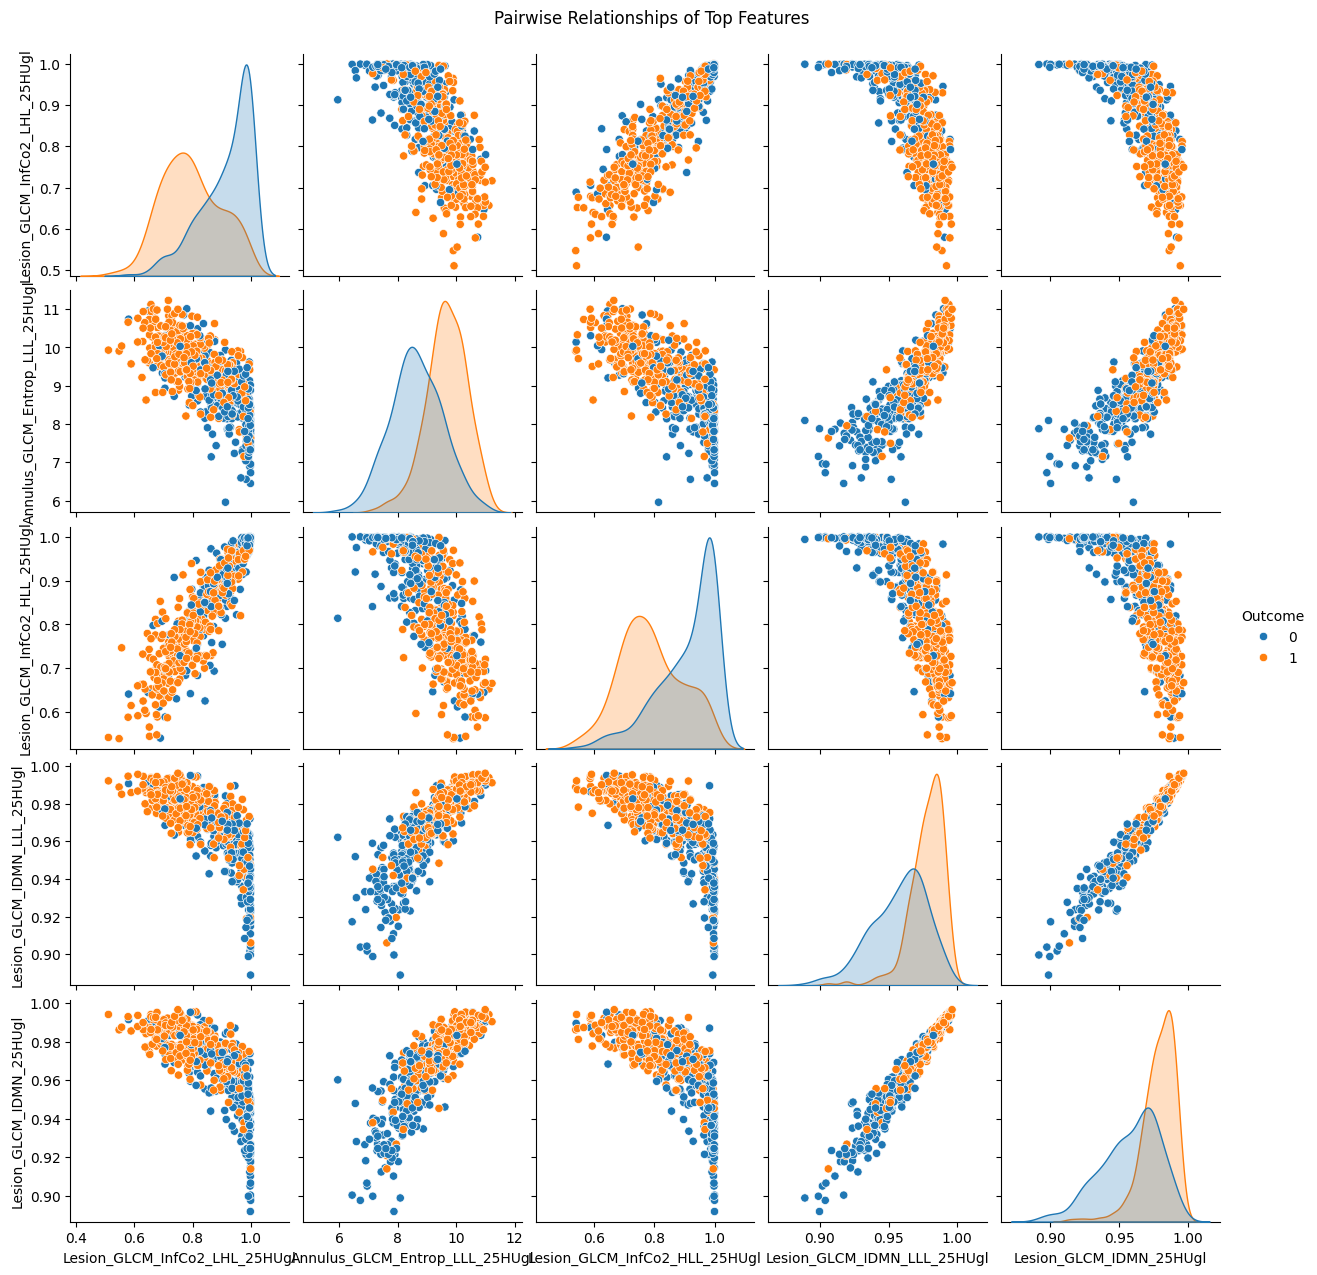

In [29]:
top_features = outcome_corr.index[1:6]  # Exclude Outcome itself
sns.pairplot(data=df[list(top_features) + ['Outcome']], hue='Outcome')
plt.suptitle('Pairwise Relationships of Top Features', y=1.02)
plt.show()

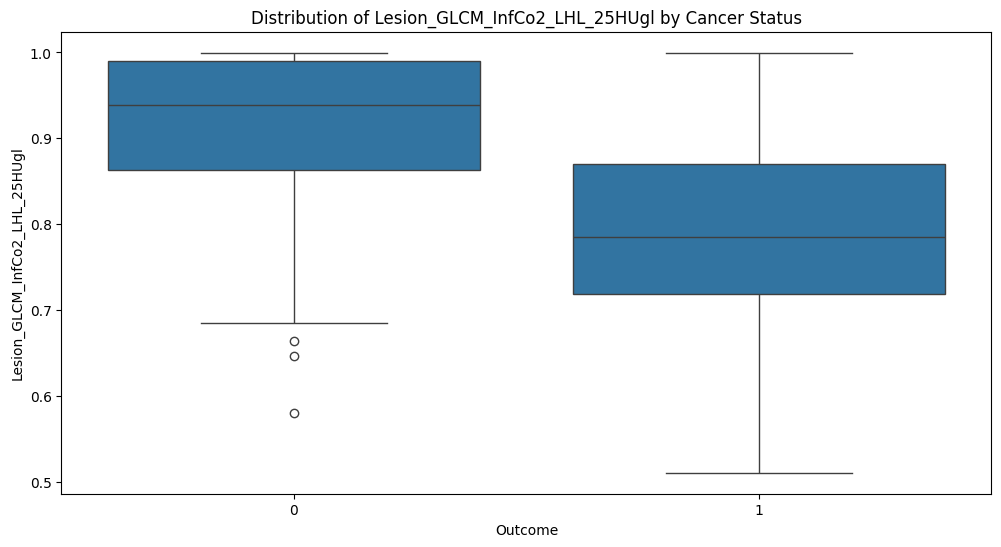

In [30]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Outcome', y=top_features[0])  
plt.title(f'Distribution of {top_features[0]} by Cancer Status')
plt.show()

In [31]:
# Check for duplicates
print(f"Duplicate Rows: {df.duplicated().sum()}")

# Examine zeros/missing values
print("\nFeatures with >30% zeros:")
print((df[numeric_cols] == 0).mean().sort_values(ascending=False).head(10))

Duplicate Rows: 0

Features with >30% zeros:
Lesion_FOS_Imode           0.011494
Annulus_FOS_Imode          0.006568
Annulus_FOS_Imode_LLL      0.001642
Annulus_FOS_Imedian_HLH    0.001642
Annulus_FOS_Imedian_LHH    0.001642
Annulus_FOS_Imode_LHH      0.001642
Annulus_FOS_Imode_HLL      0.001642
Annulus_FOS_Imode_HLH      0.001642
Annulus_FOS_Imode_HHL      0.001642
Annulus_FOS_Imode_HHH      0.001642
dtype: float64


## Data Processing

In [32]:
# Check for column name inconsistency between the training and test data
non_matching = non_matching_columns(train_data, test_data)

print("Number of Non-Matching Columns: ", len(non_matching))
print("Non-Matching Columns:\n", non_matching)

Number of Non-Matching Columns:  30
Non-Matching Columns:
 [('Annulus_N.voxels', 'Annulus_N voxels'), ('Annulus_AUC.CSH', 'Annulus_AUC-CSH'), ('Annulus_AUC.CSH_LLL', 'Annulus_AUC-CSH_LLL'), ('Annulus_AUC.CSH_LLH', 'Annulus_AUC-CSH_LLH'), ('Annulus_AUC.CSH_LHL', 'Annulus_AUC-CSH_LHL'), ('Annulus_AUC.CSH_LHH', 'Annulus_AUC-CSH_LHH'), ('Annulus_AUC.CSH_HLL', 'Annulus_AUC-CSH_HLL'), ('Annulus_AUC.CSH_HLH', 'Annulus_AUC-CSH_HLH'), ('Annulus_AUC.CSH_HHL', 'Annulus_AUC-CSH_HHL'), ('Annulus_AUC.CSH_HHH', 'Annulus_AUC-CSH_HHH'), ('Background_N.voxels', 'Background_N voxels'), ('Background_AUC.CSH', 'Background_AUC-CSH'), ('Background_AUC.CSH_LLL', 'Background_AUC-CSH_LLL'), ('Background_AUC.CSH_LLH', 'Background_AUC-CSH_LLH'), ('Background_AUC.CSH_LHL', 'Background_AUC-CSH_LHL'), ('Background_AUC.CSH_LHH', 'Background_AUC-CSH_LHH'), ('Background_AUC.CSH_HLL', 'Background_AUC-CSH_HLL'), ('Background_AUC.CSH_HLH', 'Background_AUC-CSH_HLH'), ('Background_AUC.CSH_HHL', 'Background_AUC-CSH_HHL'), ('

In [33]:
def standardize_colnames(df):
    df.columns = df.columns.str.replace(r'(\.| )', '-', regex=True)  # Replace both dots and spaces with hyphens
    return df

# Apply to both datasets
train_data = standardize_colnames(train_data)
test_data = standardize_colnames(test_data)

In [34]:
# After fixing, verify alignment
assert set(train_data.columns) == set(test_data.columns), "Columns still don't match!"
print("All columns now match!")

All columns now match!


In [35]:
# Select top 10 correlated features + Outcome
top_features = outcome_corr.index[:11].tolist()  # Includes Outcome
df_filtered = df[top_features]

In [37]:
df['log_Lesion_GLCM_InfCo2_LHL'] = np.log1p(df['Lesion_GLCM_InfCo2_LHL_25HUgl'])

In [38]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", cat_cols.tolist())

Categorical columns: ['ID']


In [39]:
df = df.drop('ID', axis=1)

In [40]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
print("Remaining categorical columns:", cat_cols.tolist())  

Remaining categorical columns: []


In [41]:
if len(cat_cols) > 0:
    
    # Correct modern syntax (sparse_output=False instead of sparse=False)
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_cols = encoder.fit_transform(df[cat_cols])
    
    # Create DataFrame with new encoded columns
    encoded_df = pd.DataFrame(
        encoded_cols,
        columns=encoder.get_feature_names_out(cat_cols)
    )
    
    # Combine with numeric columns
    df_processed = pd.concat([
        df.drop(cat_cols, axis=1),
        encoded_df
    ], axis=1)
else:
    df_processed = df.copy()

In [42]:
print("\nProcessed Data Shape:", df_processed.shape)
display(df_processed.head(2))


Processed Data Shape: (609, 2000)


,Annulus_N.voxels,Annulus_SNS_vol,Annulus_SNS_area,Annulus_SNS_s2v,Annulus_SNS_sph,Annulus_SNS_sph_dis,Annulus_SNS_com_1,Annulus_SNS_com_2,Annulus_SNS_max3d,Annulus_FOS_CV,...,Lesion_GLCM_difVar_HHH_25HUgl,Lesion_GLCM_difEnt_HHH_25HUgl,Lesion_GLCM_AutoCorrel_HHH_25HUgl,Lesion_GLCM_ClTend_HHH_25HUgl,Lesion_GLCM_Homoge1_HHH_25HUgl,Lesion_GLCM_IDMN_HHH_25HUgl,Lesion_GLCM_IDN_HHH_25HUgl,Lesion_GLCM_invVar_HHH_25HUgl,Outcome,log_Lesion_GLCM_InfCo2_LHL
0,1504,1504,3364,2.236702,0.188709,5.299155,3.779511,0.006720,21,-0.134648,...,0.516489,1.478822,12.359264,1.122325,0.672912,0.972564,0.898164,0.519051,0,0.639226
1,1007,1007,2224,2.208540,0.218459,4.577528,3.334505,0.010426,16,-0.181334,...,0.535239,1.502895,12.134616,1.132018,0.675078,0.971933,0.898085,0.502191,0,0.636260


### Scalling and Spltting Data

In [43]:
# Separate features and target
X = df_processed.drop('Outcome', axis=1)
y = df_processed['Outcome']

# Scale only numeric features (excluding Outcome)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_processed = pd.DataFrame(X_scaled, columns=X.columns)

In [44]:
top_features = [
    'Outcome',
    'Lesion_GLCM_InfCo2_LHL_25HUgl',
    'Annulus_GLCM_Entrop_LLL_25HUgl',
    'Lesion_GLCM_InfCo2_HLL_25HUgl',
    'Lesion_GLCM_IDMN_LLL_25HUgl',
    'Lesion_GLCM_IDMN_25HUgl',
    'Lesion_GLCM_InfCo2_LLH_25HUgl',
    'Lesion_GLCM_InfCo2_LHH_25HUgl',
    'Lesion_GLCM_IDN_LLL_25HUgl',
    'Lesion_GLCM_InfCo1_LLL_25HUgl'
]
df_final = df[top_features]

In [45]:
X = df_final.drop('Outcome', axis=1)
y = df_final['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [46]:
# Get top 50 features most correlated with 'Outcome'
correlations = train_data.corr()['Outcome'].abs().sort_values(ascending=False)
top_50_features = correlations.head(50).index.tolist()

# Filter datasets
X_train = train_data[top_50_features]
y_train = train_data['Outcome']
X_test = test_data[top_50_features]
y_test = test_data['Outcome']

## Training Models

### XGB Classifier

In [47]:
model = XGBClassifier(
    scale_pos_weight=sum(y_train==0)/sum(y_train==1),  # Handles slight imbalance
    eval_metric='logloss',
    n_estimators=200,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred_proba = model.predict_proba(X_test)[:,1]
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

Test ROC-AUC: 1.000


### Random Forest Classifier

In [48]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# Feature importance visualization
pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

,Feature,Importance
0,Outcome,0.424308
29,Annulus_GLSZM_SzNonUnif_LLL_25HUgl,0.050791
2,Annulus_GLCM_Entrop_LLL_25HUgl,0.042643
44,Annulus_GLSZM_GlVarianc_LLL_25HUgl,0.032845
41,Annulus_GLRLM_RLN_25HUgl,0.031759
7,Lesion_GLCM_InfCo2_LHH_25HUgl,0.028898
14,Lesion_GLCM_InfCo1_HLL_25HUgl,0.026733
1,Lesion_GLCM_InfCo2_LHL_25HUgl,0.023159
4,Lesion_GLCM_IDMN_LLL_25HUgl,0.016981
21,Annulus_NGTDM_Coarse_HHH_25HUgl,0.015503


### Logistic Regression

In [49]:
model = LogisticRegression(
    penalty='l1',  # L1 regularization for feature selection
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# View coefficients
pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

,Feature,Coefficient
0,Outcome,11.049671
2,Annulus_GLCM_Entrop_LLL_25HUgl,-0.394277
10,Lesion_GLCM_Dissim_LLL_25HUgl,-0.074464
32,Lesion_GLCM_difVar_LLL_25HUgl,-0.007587
29,Annulus_GLSZM_SzNonUnif_LLL_25HUgl,0.001714
44,Annulus_GLSZM_GlVarianc_LLL_25HUgl,-0.001657
12,Lesion_GLCM_Contra_LLL_25HUgl,-0.001333
41,Annulus_GLRLM_RLN_25HUgl,-0.000496
1,Lesion_GLCM_InfCo2_LHL_25HUgl,0.000000
3,Lesion_GLCM_InfCo2_HLL_25HUgl,0.000000


#### Neural Network GPU Intensive

In [50]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # Helps prevent overfitting
    Dense(1, activation='sigmoid')  # Single output neuron for binary classification
])

# Compile with medical-appropriate settings
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='roc_auc'),  # Critical for medical diagnostics
        'accuracy'
    ]
)

# Train with validation split
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight={0: 1, 1: 1.1}  # Optional: Adjust if you have class imbalance
)

# Evaluate
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

c:\Users\Dell\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5260 - loss: 54.8054 - roc_auc: 0.5247 - val_accuracy: 0.8115 - val_loss: 7.9554 - val_roc_auc: 0.7444
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6268 - loss: 36.1345 - roc_auc: 0.6517 - val_accuracy: 0.8361 - val_loss: 7.4485 - val_roc_auc: 0.8011
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6305 - loss: 44.3184 - roc_auc: 0.6329 - val_accuracy: 0.8197 - val_loss: 7.4353 - val_roc_auc: 0.8084
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6613 - loss: 40.8331 - roc_auc: 0.6572 - val_accuracy: 0.8197 - val_loss: 7.8957 - val_roc_auc: 0.8055
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6903 - loss: 25.5029 - roc_auc: 0.7084 - val_accuracy: 0.7869 - val_loss: 7.5706 - val_roc_auc: 0.7895
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6599 - loss: 38.4262 - roc_auc: 0.6649 - val_accuracy: 0.8115 - val_loss: 6.9850 - val_roc_auc: 0.80

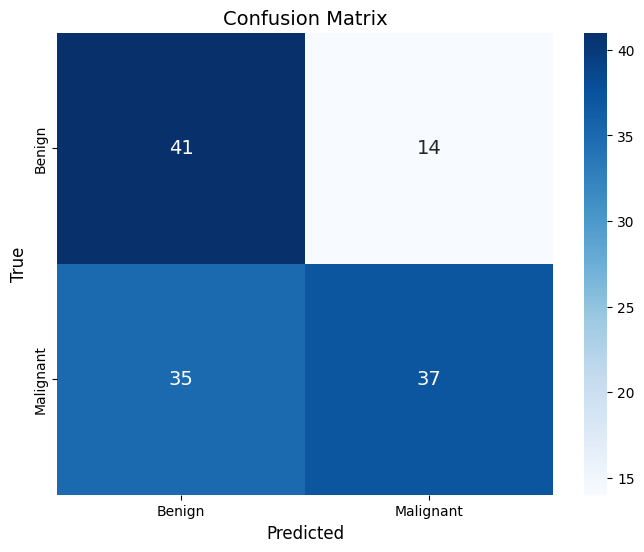


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 61.42%
Balanced Accuracy        : 62.97%
Precision (PPV)          : 72.55%
Recall (Sensitivity)     : 51.39%
Specificity              : 74.55%
F1 Score                 : 60.16%
MCC                      : 0.2621
ROC-AUC                  : 0.7394

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 35
False Positives (Overdiagnosis): 14
Sensitivity (True Positive Rate): 51.39%
Specificity (True Negative Rate): 74.55%


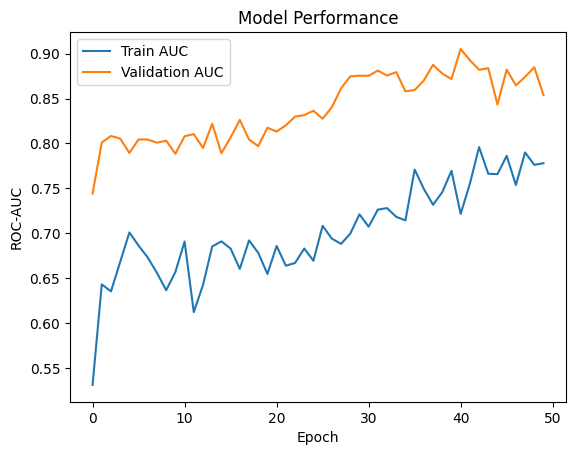

In [51]:
# With your evaluation function
evaluate_medical_model(y_test, y_pred, y_pred_proba)

# Or plot training history
plt.plot(history.history['roc_auc'], label='Train AUC')
plt.plot(history.history['val_roc_auc'], label='Validation AUC')
plt.title('Model Performance')
plt.ylabel('ROC-AUC')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Evaluation Metrics for Medical Use

In [52]:
# For binary classification threshold = 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)  

print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

NameError: name 'classification_report' is not defined

#### Shap

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Feature importance plot
shap.summary_plot(shap_values, X_test, plot_type='bar')

# Individual prediction explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'keras.src.models.sequential.Sequential'>

In [ ]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validated ROC-AUC: {scores.mean():.3f} (±{scores.std():.3f})")

TypeError: Cannot clone object '<Sequential name=sequential, built=True>' (type <class 'keras.src.models.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.